## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [201]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [202]:
df = pd.read_csv('ab_data.csv') # load the dataset
df.head() #show the 1st 5 rows 

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [203]:
len(df) # get number of rows


294478

c. The number of unique users in the dataset.

In [204]:
len(df.user_id.unique()) # get number of rows with unique ID

290584

d. The proportion of users converted.

In [205]:
#unique_users = df[df.user_id].drop_duplicates() 
df_unique = df.drop_duplicates(subset='user_id') # remove ID duplicates, to get
#unique users
len(df_unique) # check that number of rows matches the previous cell

df_unique.converted.mean() # get the average for the unique users 
#unique_users.converted.mean()
#df.groupby('user_id')['converted'].mean()

0.11956955647936569

e. The number of times the `new_page` and `treatment` don't match.

In [206]:
len(df.query('(group != "treatment" and landing_page == "new_page") or (group == "treatment" and landing_page != "new_page")')  ) 

3893

f. Do any of the rows have missing values?

In [207]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [208]:
df2 = df.query('(group == "treatment" and landing_page == "new_page") or (group != "treatment" and landing_page != "new_page")')
len(df2)

290585

In [209]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [210]:
len(df2.user_id.unique())

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [211]:
df2.user_id.duplicated().sum() # sum the duplicated IDs 

1

c. What is the row information for the repeat **user_id**? 

In [212]:
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [213]:
df2 = df2.drop_duplicates(subset='user_id') #use the user_id column as the source for removing duplicates
len(df2)

290584

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [214]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [215]:
control = df2.query('group == "control"') # get only control
len(control) # check that filtering was correct
control.converted.mean()  # get mean conversion for controls

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [216]:
ttt = df2.query('group == "treatment"') # get only control
len(ttt) # check that filtering was correct
ttt.converted.mean()  # get mean conversion for treatment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [217]:
sum(df2.landing_page == "new_page")/len(df2)

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**No enough evidence since no proper statistical tests have been applied
On the contrary, since rate of conversion is higher in the control group, maybe the new treatment page is leading to less conversions**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Null hypothesis: old page is better than or equal to the new page in the conversion rate**

**Alternative hypothesis: new page is better in the conversion rate**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [218]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [219]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [220]:
n_new = df2.query('group == "treatment"')
len(n_new)

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [221]:
n_old = df2.query('group == "control"')
len(n_old)

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [222]:
new_page_converted = np.random.choice([0, 1], size=len(n_new), p=[1 - p_new, p_new]) # a random choice of zeros and ones
# based on the proportions of p_new   reference: https://stackoverflow.com/questions/21566744/generate-random-array-of-0-and-1-with-specific-ratio


new_page_converted.mean() # a confirmatory step



0.11892505677517033

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [223]:
old_page_converted = np.random.choice([0, 1], size=len(n_old), p=[1 - p_old, p_old]) # a random choice of zeros and ones
# based on the proportions of p_old   reference: https://stackoverflow.com/questions/21566744/generate-random-array-of-0-and-1-with-specific-ratio


old_page_converted.mean() # a confirmatory step

0.11898206148381679

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [224]:
new_page_converted.mean() - old_page_converted.mean()

-5.7004708646460345e-05

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [225]:
new_means, old_means, p_diffs = [], [], []

for _ in range(10000):   # loops 10,000 times 
    new_mean = np.random.choice([0, 1], size=len(n_new), p=[1 - p_new, p_new]).mean()   # get average of sampling based on p_new
    old_mean = np.random.choice([0, 1], size=len(n_old), p=[1 - p_old, p_old]).mean()   # get average of sampling based on p_old
    # append the info 
    new_means.append(new_mean)  # updates the list above
    old_means.append(old_mean)
    p_diffs.append(new_mean - old_mean) 

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

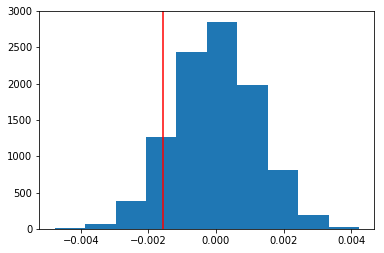

In [226]:
p_diffs = np.array(p_diffs)  # store in a numpy array

plt.hist(p_diffs)  # plot histogram

obs_diff = ttt.converted.mean() - control.converted.mean()

plt.axvline(obs_diff, c='red')   # add the vertical red line for observed difference

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [227]:
(p_diffs > obs_diff).mean() 

0.89929999999999999

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The value calculated is the p-value. It is probability of observing an event under the null hypothesis. i.e. when the null hypothesis is true. If this probability is too low, lower than a certain threshold ( mostly 0.05), then there is a very low 
probability of this event occuring under normal conditions if the null hypothesis is true. This drives us to rejecting the null hypothesis and accepting the alternative hypothesios.  
Here, our null hypothesis was that old page is equal to or better than the new page. Since the p-value is high (0.9), we will not be able to reject the null hyppothesis.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [228]:
import statsmodels.api as sm

convert_old = len(df2.query('group == "control" and converted == 1'))
convert_new = len(df2.query('group == "treatment" and converted == 1'))
n_old = len(df2.query('group == "control"'))
n_new = len(df2.query('group == "treatment"'))


convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [229]:
from statsmodels.stats.proportion import proportions_ztest
count = np.array([convert_old, convert_new])  # count is the number of sucesses 
nobs = np.array([n_old, n_new ])   # observation is the total number of cases
stat, pval = proportions_ztest(count, nobs)  # calculating z-score and p-value
print('{0:0.3f}'.format(pval))


0.190


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The z-score is too low and p-value is too high to enable us to reject the Null hypothesis. This agrees with the previous findings in parts j and k. However, p-value here is much lower than the previous p-value.  
This maybe due to the fact that we have not informed the automated function that the alternative hypothesis is that the new page is better. Thus, it was just calculating the probability that the two pages are not equal. **

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [230]:
df2['intercept'] = 1  # add the intercept column 

ab_page = pd.get_dummies(df2['group'])  # create dummy variable
df2 = df2.join(ab_page) # join the dummy variable

df2['ab_page'] = np.where(df2['treatment'] == 1, 1, 0)  # add the column ab_page, that is 1 when treatment is given
# reference : https://chrisalbon.com/python/data_wrangling/pandas_create_column_using_conditional/
df2.head()


,user_id,timestamp,group,landing_page,converted,intercept,control,treatment,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [231]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'treatment']]) # instantiate the model
results = log_mod.fit()  # fit the model


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [232]:
results.summary() #get the summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 03 Apr 2019   Pseudo R-squ.:               8.077e-06
Time:                        13:08:32   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
treatment     -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**0.190**  
Null hypothesis with regression model: treatment = control  
Alternative hypothesis with regression model: treatment != control  

Null hypothesis in part II : treatment <= control  
Alternative hypothesis with regression model: treatment > control  

Thus, p-value is much higher in part 2. In regression, any deviation from equality would reduce the p-value. However, in part 2, deviation from equality in favor of the control group increases the p-value

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**It is good to add other factors to adjust for confounders so that we can make sure that results are due to the tested factor, keeping all other interfering factors constant.
Disadvantages can show up in the form of multicollinearity, where independent variables may be correlated to each others, interfering with the results. Moreover, too much independent variables may cause the problem of overfitting and may require a larger sample size.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [233]:
data = pd.read_csv('countries.csv') # loading data
data.head() # viewing a glimpse

df2 = df2.set_index('user_id').join(data.set_index('user_id')) # joining the dataframes on user_id

df2.head()

,timestamp,group,landing_page,converted,intercept,control,treatment,ab_page,country
user_id,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,0,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,0,US
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,1,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,0,US


In [234]:
cntry = pd.get_dummies(df2['country'])  # create dummy variable
df2 = df2.join(cntry) # join the dummy variable


In [235]:
df2.head()

log_mod2 = sm.Logit(df2['converted'], df2[['intercept', 'treatment', 'CA', 'UK']]) # instantiate the model, setting US as the reference
results = log_mod2.fit()  # fit the model
results.summary() #get the summary

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 03 Apr 2019   Pseudo R-squ.:               2.323e-05
Time:                        13:08:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
treatment     -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

Addition of country was not useful. Both countries are not significant. In addition, the pseudo R squared and log-likelihood ratio were not changed. Thus, model performance has not improved. 

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [236]:
df2['country_page'] = df2['ab_page']*df2['US'] # creating the interaction term 

df2.head() # checking 

log_mod3 = sm.Logit(df2['converted'], df2[['intercept', 'treatment', 'CA', 'UK', 'country_page']]) # instantiate the model, setting US as the reference

results = log_mod3.fit()  # fit the model

results.summary() #get the summary


Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Wed, 03 Apr 2019   Pseudo R-squ.:               2.589e-05
Time:                        13:08:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.2390
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -1.9865      0.010   -206.344      0.000      -2.005      -1.968
treatment       -0.0018      0.021     -0.086      0.931      -0.043       0.039
CA              -0.0501      0.030     -1.691      0.091      -0.108       0.008
UK               0.0006      0.018      0.031      0.975      -0.035       0.036
country_page    -0.0188      0.025     -0.752      0.452      -0.068       0.030
================================================================================
"""

Again the p-value for the interaction term is not significant. There is only a slight increase in pseudo R squared.

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [238]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0